# 实验 3.7 – 学员笔记本

## 概述

本实验是模块 3 引导式实验的延续。

在本实验中，您将创建一个超参数优化作业，对以前创建的模型进行优化。然后，您将比较两个模型的指标。


## 业务场景简介

您在一家医疗保健服务提供商工作，并希望改善骨科患者的异常检测。

您的任务是利用机器学习 (ML) 解决此问题。您可以使用包含六个生物力学特征且目标为*正常*或*异常*的数据集。您可以使用此数据集训练 ML 模型，以预测患者是否会出现异常。


## 关于该数据集

该生物医学数据集由 Henrique da Mota 博士在法国里昂 Médico-Chirurgical de Réadaptation des Massues 中心的整形外科应用研究组 (GARO) 实习期间创建。这些数据用于两个不同但相关的分类任务。

第一项任务是将患者划分为以下三个类别： 

- *正常*（100 名患者）
- *椎间盘疝*（60 名患者）
- *脊椎滑脱*（150 名患者）

第二个任务则是将*椎间盘疝*和*脊椎滑脱*合并为一个类别，标记为*异常*。因此，在第二个任务中，患者分为两个类别：*正常*（100 名患者）或*异常*（210 名患者）。


## 属性信息

数据集中的每名患者都由六个生物力学属性表示，这些属性（顺序如下）是根据骨盆和腰椎的形状和方向得出的： 

- 骨盆入射角
- 骨盆倾斜角
- 腰椎前凸角
- 骶骨倾斜角
- 骨盆半径
- 脊椎滑脱等级

以下约定用于分类标签： 
- 椎间盘疝 (DH)
- 脊椎滑脱 (SL)
- 正常 (NO) 
- 异常 (AB)


有关此数据集的更多信息，请参阅[脊柱数据集网页](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column)。


## 数据集属性

该数据集来自：
Dua, D. 和 Graff, C.（2019 年）。UCI 机器学习存储库 (http://archive.ics.uci.edu/ml)。加州尔湾市：加利福尼亚大学信息与计算机科学学院。


# 实验设置

由于此解决方案分散在模块中的多个实验中，因此您需要运行以下单元格中的内容，以便加载数据并训练要部署的模型。

**注意**：设置过程最多可能需要 5 分钟。

## 导入数据并训练、测试和验证模型

通过运行以下单元格中的内容，将导入数据，并将训练、测试和验证模型，让模型可供使用。

**注意**：以下单元格中的内容代表以前的实验中的关键步骤。

要优化模型，必须先准备好模型，然后才能在后面的步骤 2 中使用超参数调整模型。

In [1]:
bucket='c130335a3301606l7986146t1w373590610266-labbucket-tpobvfpyzlsy'

In [2]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


**注意**：完成以下单元格中的内容大约需要 **10** 分钟。观察代码及其处理过程，这将有助于您更好地了解后台发生了什么。请记住，该单元格中的内容完成了您在本模块前几个实验中完成的所有步骤，包括：
 - 导入数据
 - 将数据加载到 DataFrame 中
 - 将数据分割成训练、测试和验证数据集
 - 将分割的数据集上传到 S3
 - 用数据集训练、测试和验证模型

In [3]:
%%time

def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic",
             "silent" : 1}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-17-04-28-31-568



2024-10-17 04:28:32 Starting - Starting the training job.
2024-10-17 04:28:45 Starting - Preparing the instances for training...
2024-10-17 04:29:07 Downloading - Downloading input data...
2024-10-17 04:29:22 Downloading - Downloading the training image......
2024-10-17 04:29:58 Training - Training image download completed. Training in progress.....
2024-10-17 04:30:23 Uploading - Uploading generated training model
2024-10-17 04:30:32 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-17-04-30-33-283


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-10-17-04-30-34-045


..................................2024-10-17T04:36:15.758:[sagemaker logs]: MaxConcurrentTransforms=8, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2024-10-17:04:36:10:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-17:04:36:10:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-17:04:36:10:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
[2024-10-17:04:36:10:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-17:04:36:10:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-17:04:36:10:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    l

# 步骤 1：获取模型统计数据

在优化模型之前，请再次熟悉当前模型的指标。

该设置执行批量预测，因此您必须从 Amazon Simple Storage Service (Amazon S3) 中读取结果。

In [4]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]



绘制原始模型的混淆矩阵和受试者操作特征 (ROC) 曲线。


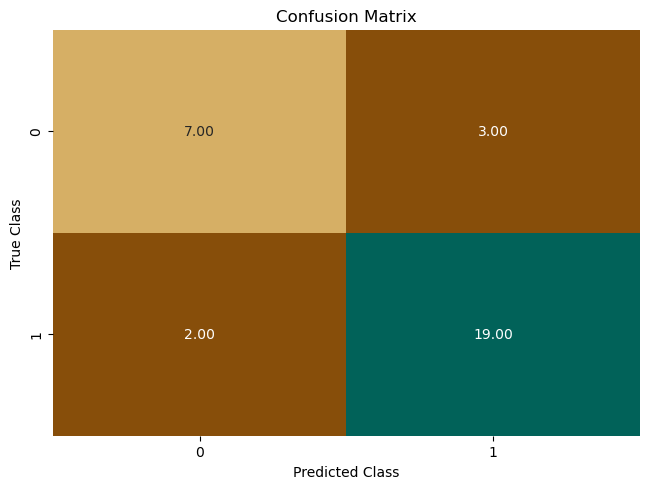

In [5]:
plot_confusion_matrix(test_labels, target_predicted_binary)

## 修正以上的錯誤

In [6]:
import numpy as np

# 檢查數據中是否有 NaN 或 Inf，並進行替換
if target_predicted_binary.isnull().any() or test_labels.isnull().any():
    print("警告：有 NaN 值")
    target_predicted_binary = target_predicted_binary.fillna(0)
    test_labels = test_labels.fillna(0)

# 確保沒有 Inf 值
target_predicted_binary = target_predicted_binary.replace(
    [np.inf, -np.inf], 0
)
test_labels = test_labels.replace(
    [np.inf, -np.inf], 0
)

# 修正這個函數
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity = float(TP) / (TP + FN) * 100
    # Specificity or true negative rate
    Specificity = float(TN) / (TN + FP) * 100
    # Precision or positive predictive value
    Precision = float(TP) / (TP + FP) * 100
    # Negative predictive value
    NPV = float(TN) / (TN + FN) * 100
    # Fall out or false positive rate
    FPR = float(FP) / (FP + TN) * 100
    # False negative rate
    FNR = float(FN) / (TP + FN) * 100
    # False discovery rate
    FDR = float(FP) / (TP + FP) * 100
    # Overall accuracy
    ACC = float(TP + TN) / (TP + FP + FN + TN) * 100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print(f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    # 計算 ROC AUC
    roc_auc = roc_auc_score(test_labels, target_predicted_binary)
    print("Validation AUC", roc_auc)

    # 計算 ROC 曲線
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    # 繪製 ROC 曲線
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')

    # 檢查 thresholds 中是否有 NaN 或 Inf 值
    valid_thresholds = thresholds[np.isfinite(thresholds)]
    if len(valid_thresholds) > 0:
        ax2.set_ylim([valid_thresholds[-1], valid_thresholds[0]])
    else:
        print("警告：沒有有效的閾值範圍")

    ax2.set_xlim([fpr[0], fpr[-1]])

    plt.show()

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%
Validation AUC 0.8023809523809523


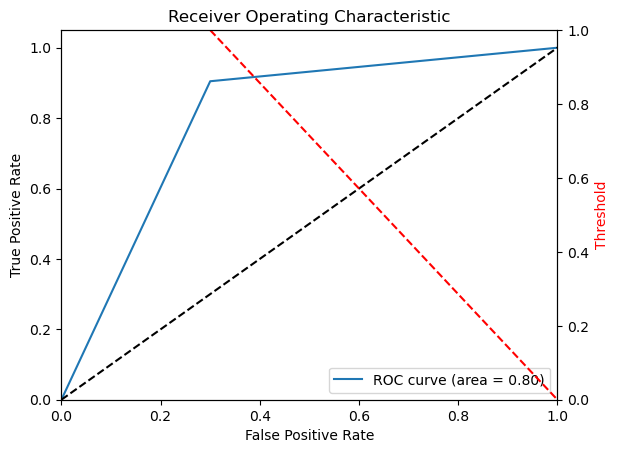

In [7]:
plot_roc(test_labels, target_predicted_binary)

此图为您提供了一个起点。记下*曲线下有效面积 (AUC)*。您稍后将使用它来检查优化后的模型，以确认模型是否切实得到了提升。

# 步骤 2：创建超参数优化作业

超参数优化作业可能需要几个小时才能完成，具体取决于您提供的值的范围。为了简化此任务，此步骤中使用的参数是建议范围的子集。在本实验中，它们经过优化以提供良好的结果，而无需花费多个小时来完成。

有关针对 XGBoost 优化参数的更多信息，请参阅 AWS 文档中的 [优化 XGBoost 模型](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html)。

因为下一个单元格的内容大约需要 **45** 分钟才能完成，所以请先运行它。您将详细了解发生的情况，以及为什么选择这些超参数范围。

In [8]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


xgb.set_hyperparameters(eval_metric='error@.40',
                        objective='binary:logistic',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-241017-0437


.....................................................................................................................!
!
CPU times: user 693 ms, sys: 45.1 ms, total: 738 ms
Wall time: 10min 9s


首先，您将创建要优化的模型。

```
xgb = sagemaker.estimator.Estimator(container,
                                   role=sagemaker.get_execution_role(),
                                   instance_count= 1, # 确保您针对这些实例设置了限制
                                   instance_type='ml.m4.xlarge',
                                   output_path='s3://{}/{}/output'.format(bucket, prefix),
                                   sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(eval_metric='[error@.40]',
                        objective='binary:logistic',
                        num_round=42)

```                        

注意，模型的 *eval_metric* 更改为 *error@.40*，目的是使该值最小化。

**error** 是二元分类错误率。计算方法为 *#（错误案例）/#（所有案例）*。对于预测，评估会将预测值大于 0.4 的实例视为阳性实例，而其他实例则视为阴性实例。

接下来，除了必须为每个参数选择范围之外，还必须指定要优化的超参数。

对 XGBoost 目标指标影响最大的超参数包括： 

- alpha
- min_child_weight
- subsample
- eta
- num_round 

推荐的优化范围可以在 AWS 文档的 [优化 XGBoost 模型](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) 中找到。

在本实验中，您将使用值的*子集*。这些值是通过在整个范围内运行优化作业，然后将范围最小化而获得的，以便可以使用更少的迭代来获得更好的性能。尽管这种做法并非严格可行，但它可以让您不必在本实验中花几个小时等待优化作业完成。

```
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3), 
                         'num_round': IntegerParameter(1,50)
                         }
```


您必须指定如何评估模型。您可以使用几种不同的客观指标，其中一部分适用于二元分类问题。由于评估指标为 **error**，因此您应将目标设置为 *error*。

```
objective_metric_name = 'validation:error'
objective_type = 'Minimize'
```

最后，运行优化作业。

```
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # 根据预算和可用时间，将此项设置为 10 或更大值。
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()
```



<i class="fas fa-exclamation-triangle" style="color:red"></i> 等待训练作业完成。最长可能需要 **45** 分钟。在等待期间，请按照以下说明在控制台中观察作业状态。

**要监控超参数优化作业，请执行以下操作**：  

1.在 AWS 管理控制台的 **Services**（服务）菜单中，选择 **Amazon SageMaker**。 
2.选择 **Training > Hyperparameter tuning jobs**（训练 > 超参数优化作业）。 
3.您可以查看每个超参数优化作业的状态、目标指标值和日志。 

训练作业完成后，检查该作业以确保其成功完成。

In [9]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

# 步骤 3：调查优化作业结果

现在作业已完成，应该有 10 个已完成的作业。其中一项作业应标记为最佳。

您可以通过获取 *HyperparameterTuningJobAnalytics* 并将这些数据加载到 pandas DataFrame 中来检查指标。


In [10]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,20.955703,0.107112,3.315354,14.0,0.796228,sagemaker-xgboost-241017-0437-007-6b6275ad,Completed,0.19355,2024-10-17 04:43:53+00:00,2024-10-17 04:44:22+00:00,29.0
0,15.457867,0.300000,3.353466,1.0,0.931666,sagemaker-xgboost-241017-0437-010-fe7520ca,Completed,0.22581,2024-10-17 04:46:29+00:00,2024-10-17 04:46:58+00:00,29.0
1,23.759144,0.283555,3.349783,28.0,0.500000,sagemaker-xgboost-241017-0437-009-322807dd,Completed,0.22581,2024-10-17 04:45:35+00:00,2024-10-17 04:46:09+00:00,34.0
2,22.795671,0.100000,3.174829,1.0,0.932180,sagemaker-xgboost-241017-0437-008-c1709935,Completed,0.22581,2024-10-17 04:44:42+00:00,2024-10-17 04:45:16+00:00,34.0
5,24.605616,0.177266,3.125217,21.0,0.900531,sagemaker-xgboost-241017-0437-005-4f285e6b,Completed,0.22581,2024-10-17 04:42:05+00:00,2024-10-17 04:42:34+00:00,29.0
7,30.555890,0.128453,3.199260,4.0,0.870850,sagemaker-xgboost-241017-0437-003-c963a5d6,Completed,0.22581,2024-10-17 04:40:44+00:00,2024-10-17 04:41:13+00:00,29.0
4,100.000000,0.291310,2.775591,12.0,0.532675,sagemaker-xgboost-241017-0437-006-7696f97c,Completed,0.67742,2024-10-17 04:43:05+00:00,2024-10-17 04:43:34+00:00,29.0
6,48.016410,0.186424,3.884603,10.0,0.697354,sagemaker-xgboost-241017-0437-004-71043ea8,Completed,0.67742,2024-10-17 04:41:24+00:00,2024-10-17 04:41:52+00:00,28.0
8,76.562875,0.112504,3.317089,17.0,0.786436,sagemaker-xgboost-241017-0437-002-ce291597,Completed,0.67742,2024-10-17 04:40:04+00:00,2024-10-17 04:40:33+00:00,29.0
9,69.187563,0.294456,4.543100,41.0,0.967627,sagemaker-xgboost-241017-0437-001-7c28fcda,Completed,0.67742,2024-10-17 04:37:50+00:00,2024-10-17 04:39:34+00:00,104.0


您应该能够看到每个作业使用的超参数以及得分。您可以使用这些参数并创建模型，也可以通过超参数优化作业来获得最佳模型。

In [11]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

现在，您必须连接到最佳训练作业并创建模型。

In [12]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2024-10-17 04:44:40 Starting - Found matching resource for reuse
2024-10-17 04:44:40 Downloading - Downloading the training image
2024-10-17 04:44:40 Training - Training image download completed. Training in progress.
2024-10-17 04:44:40 Uploading - Uploading generated training model
2024-10-17 04:44:40 Completed - Resource reused by training job: sagemaker-xgboost-241017-0437-008-c1709935


然后，可以使用转换方法通过使用测试数据来执行批量预测。请记住，测试数据是模型从未见过的数据。

In [ ]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-17-04-47-19-718
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-10-17-04-47-20-316


.......................................

获取模型的预测目标和测试标签。

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
best_target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = best_target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

为 `best_target_predicted` 和 `test_labels` 绘制混淆矩阵。

In [ ]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

绘制 ROC 图。

In [ ]:
plot_roc(test_labels, best_target_predicted_binary)

**问题**：这些结果与原始结果有何不同？ 这些结果是变好还是变差了？ 

结果并不一定变好。出现这种结果，可能有以下几个原因：

- 该模型从初始阶段可能就已经有了较好的效果（*好*是主观的）。
- 您没有大量的数据用于训练。
- 您在本实验中使用超参数优化范围的*子集*来节省时间。

增加超参数范围（如文档所建议）并运行 30 个以上的作业通常可改善模型。但是，此过程将需要 2–3 个小时才能完成。

# 恭喜！

您已经完成了本实验内容，现在可以按照实验指南中的说明结束本实验内容。


